In [2]:
import torch, gc

In [4]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [5]:
!pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 9.4 MB/s eta 0:00:00


In [6]:
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')


def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])

  texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:
from torch import nn
from math import sqrt


class MultiHeadAttention(nn.Module):
    #input_dim = 임베딩 차원 / d_model = q,k,v가 가질 차원의 크기
  def __init__(self, input_dim, d_model, n_heads):
    super().__init__()
    try:
        self.input_dim = input_dim
        self.d_prime_model = int(round(d_model/n_heads,0))
        self.n_heads = n_heads
    except round(d_model/n_heads,0) % n_heads is not 0:
        print('round(d_model/n_heads,0) % n_heads is not 0')

    self.wq = nn.Linear(input_dim, d_model) #쿼리벡터 생성
    self.wk = nn.Linear(input_dim, d_model) #키 벡터 생성
    self.wv = nn.Linear(input_dim, d_model) #밸류 벡터 생성
    self.dense = nn.Linear(d_model, d_model) #어텐션 최종 out 을 위해.
    self.softmax = nn.Softmax(dim=-1)


  def forward(self, x, mask):
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    # B S H D' 에서 B H S D'으로 변경 필요
    # B S H D' 은 batch 안에 sequentioal가 key인 H vs D' 행렬이 존재하므로 Head가 종속적
    # B H S D'은 batch 안에 head가 key 인 S vs D' 행렬이 존재 하므로 Head가 독립적
    q = q.view(q.shape[0], q.shape[1], self.n_heads, self.d_prime_model).transpose(1,2)
    k = k.view(k.shape[0], k.shape[1], self.n_heads, self.d_prime_model).transpose(1,2)
    v = v.view(v.shape[0], v.shape[1], self.n_heads, self.d_prime_model).transpose(1,2)

    # B H S D' * B H D' S = B H S S
    # 각 head에 따른 상관도를 확인 가능
    score = torch.matmul(q, k.transpose(-1, -2))
    score = score / sqrt(self.d_prime_model)

    if mask is not None:
    #마스크가 있다면 실행, 마스크가 있는곳은 1로 되어져있으므로 가장 작은수를 곱하고 더함
    #soft max 함수 이후에 0에 근사함
    #mask(B S S) 와 현 score(B H S S) 텐서 형식이 다르므로 통일 해줘야함.
        mask = mask.unsqueeze(1)
    #unsqueeze를 통해 B 1 S S로 만듬
        score = score + (mask * -1e9)

    score = self.softmax(score) # B H S S
    result = torch.matmul(score, v) # B H S D'
    result = result.transpose(1,2).contiguous()
    result = result.view(result.shape[0], result.shape[1], -1) # B S D
    result = self.dense(result)
    return result

<>:13: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:13: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-7-3823226e4400>:13: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  except round(d_model/n_heads,0) % n_heads is not 0:


In [8]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff, dropout):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.MHA = MultiHeadAttention(input_dim, d_model, 4)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )
    self.dropout1 = nn.Dropout(p=dropout)  # 적절한 p 값을 설정
    self.dropout2 = nn.Dropout(p=dropout)  # 적절한 p 값을 설정

    self.layer_norm1 = nn.LayerNorm(d_model)  # Layer Normalization 정의
    self.layer_norm2 = nn.LayerNorm(d_model)  # Layer Normalization 정의

  def forward(self, x, mask):
    x1 = self.MHA(x, mask)
    x1 = self.dropout1(x1)
    x1 = self.layer_norm1(x1 + x)

    x2 = self.ffn(x1)
    x2 = self.dropout2(x2)
    x2 = self.layer_norm2(x2 + x1)

    return x2

In [9]:
import numpy as np

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


In [10]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff, dropout):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff, dropout) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, 1)

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]
    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    x = self.classification(x)

    return x


In [11]:
from torch.optim import Adam

lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()

import numpy as np
import matplotlib.pyplot as plt

def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data

    preds = model(inputs)
    # preds = torch.argmax(preds, dim=-1)
    preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [12]:
train_acc_list = []
test_acc_list = []

def train_and_test(n_epochs, dropout):
    model = TextClassifier(len(tokenizer), 32, 5, 32, dropout)
    optimizer = Adam(model.parameters(), lr=lr)

    n_epochs = n_epochs

    for epoch in range(n_epochs):
        total_loss = 0.
        model.train()

        for data in train_loader:
            model.zero_grad()
            inputs, labels = data
            inputs, labels = inputs, labels.float()
            preds = model(inputs)[..., 0]
            loss = loss_fn(preds, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()


        print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

        with torch.no_grad():
            model.eval()
            train_acc = accuracy(model, train_loader)
            test_acc = accuracy(model, test_loader)
            print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")
            train_acc_list.append(train_acc*100)
            test_acc_list.append(test_acc*100)

In [14]:
import numpy as np
train_and_test(3, 0.4)

Epoch   0 | Train Loss: 214.89658311009407
=========> Train acc: 0.810 | Test acc: 0.773
Epoch   1 | Train Loss: 150.56986884772778
=========> Train acc: 0.878 | Test acc: 0.821
Epoch   2 | Train Loss: 121.29590398073196
=========> Train acc: 0.914 | Test acc: 0.834


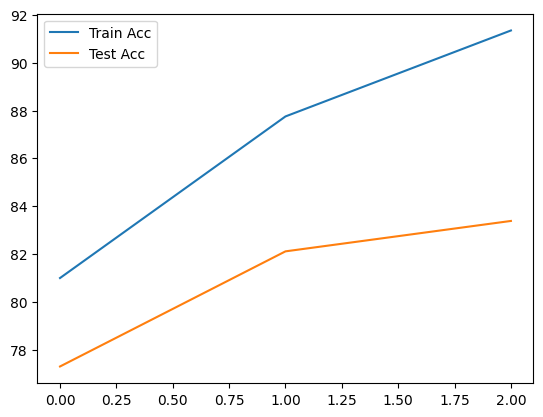

In [15]:
plt.plot(train_acc_list, label = 'Train Acc')
plt.plot(test_acc_list, label = 'Test Acc')
plt.legend()
plt.show()